In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms

Load in the dataset and binary classify into sperm (normal & abnormal) and non-sperm


In [14]:
DATA_DIR = Path("../data/SMIDS")

assert (DATA_DIR).exists(), "Dataset not found — check path!"

In [15]:
def load_dataset():
    mapping = {
        "Normal_Sperm": 1,
        "Abnormal_Sperm": 1,
        "Non-Sperm": 0
    }

    rows = []
    for folder, label in mapping.items():
        for p in (DATA_DIR / folder).glob("*"):
            rows.append({"path": str(p), "label": label})
    return pd.DataFrame(rows)


df = load_dataset()
df.head()

,path,label
0,../data/SMIDS/Normal_Sperm/Normal_Sperm (797).bmp,1
1,../data/SMIDS/Normal_Sperm/Normal_Sperm (1004)...,1
2,../data/SMIDS/Normal_Sperm/Normal_Sperm (282).bmp,1
3,../data/SMIDS/Normal_Sperm/Normal_Sperm (778).bmp,1
4,../data/SMIDS/Normal_Sperm/Normal_Sperm (328).bmp,1


Print out some sample images to sanity check binary classification

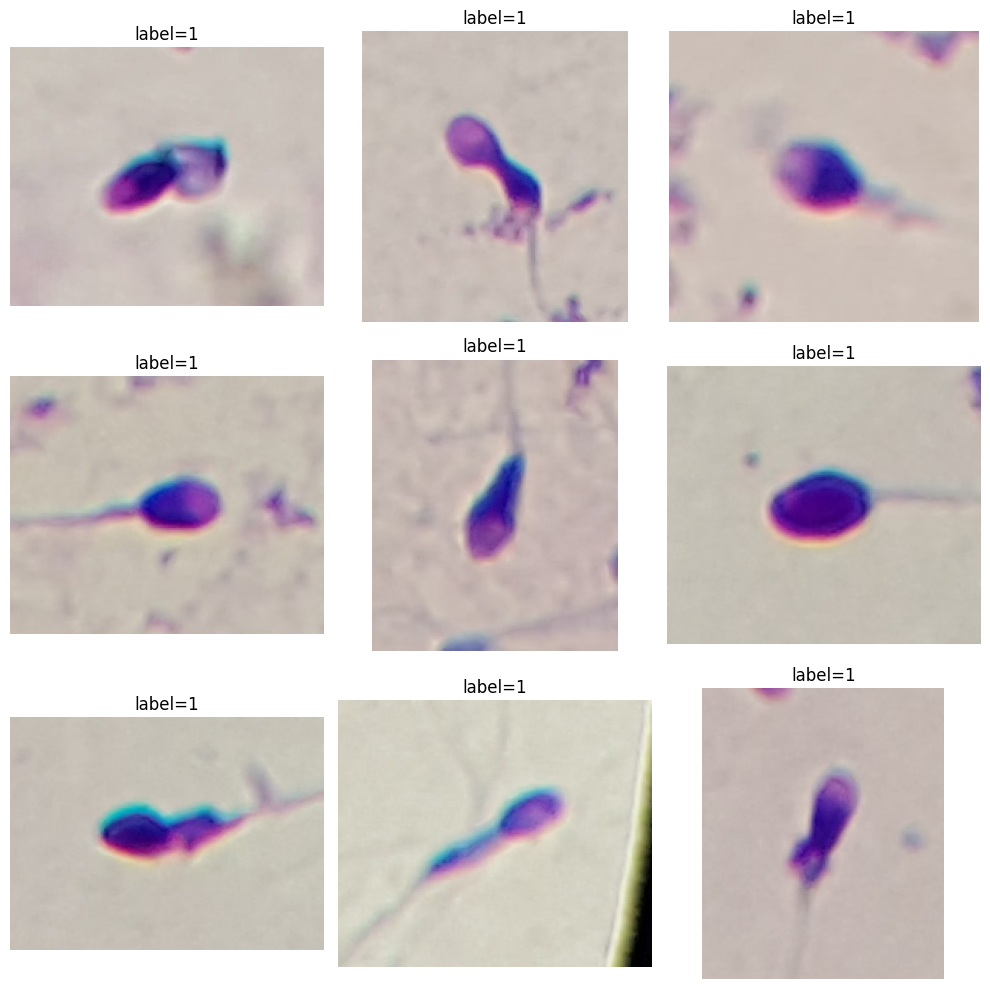

In [16]:
plt.figure(figsize=(10, 10))

for i in range(9):
    row = df.sample(1).iloc[0]
    img = Image.open(row.path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"label={row.label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

 Separate data set into training and validation sets

In [17]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df.label,
    random_state=42
)

len(train_df), len(val_df)

(2400, 600)

In [18]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


class SpermDataset(Dataset):
    def __init__(self, frame):
        self.frame = frame.reset_index(drop=True)

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        img = transform(img)
        label = torch.tensor([row.label], dtype=torch.float32)
        return img, label

In [19]:
train_loader = DataLoader(SpermDataset(train_df), batch_size=64, shuffle=True)
val_loader = DataLoader(SpermDataset(val_df), batch_size=6)

In [20]:
def create_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model.to("cpu")


model = create_model()

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 5

In [22]:
def train_epoch():
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to("cpu"), labels.to("cpu")
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

In [23]:
@torch.no_grad()
def evaluate():
    model.eval()
    preds, trues = [], []

    for imgs, labels in val_loader:
        imgs = imgs.to("cpu")
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

        preds.extend((probs > 0.5).astype(int))
        trues.extend(labels.numpy().flatten().astype(int))

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds)
    return acc, f1

In [ ]:
for epoch in range(EPOCHS):
    train_epoch()
    acc, f1 = evaluate()
    print(f"Epoch {epoch + 1}/{EPOCHS} — acc={acc:.3f}  f1={f1:.3f}")

Epoch 1/5 — acc=0.928  f1=0.949
Epoch 2/5 — acc=0.942  f1=0.958
